In [1]:
import os
import re
import os.path as osp
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tqdm
import plotnine as pn
import warnings
from tcre.env import *
from tcre import lib
from ptkn import protein_tokenization as ptkn

# %run ../env.py
# %run ../src/lib.py
# %run src/protein_tokenization.py

In [2]:
df_tag = pd.read_csv(osp.join(DATA_DIR, 'articles', 'corpus', 'corpus_01', 'tags-union.csv'))
pd.set_option('display.max_info_rows', 10000000)
df_tag.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2310512 entries, 0 to 2310511
Data columns (total 11 columns):
end_chr       2310512 non-null int64
end_wrd       2310512 non-null int64
ent_id        961277 non-null object
ent_lbl       961277 non-null object
ent_prefid    961277 non-null object
ent_src       2310512 non-null object
id            2310512 non-null object
start_chr     2310512 non-null int64
start_wrd     2310512 non-null int64
text          2310512 non-null object
type          2310512 non-null object
dtypes: int64(4), object(7)
memory usage: 193.9+ MB


In [3]:
df_tag['ent_src'].value_counts()

jnlpba    1349235
lkp        961277
Name: ent_src, dtype: int64

In [4]:
df_tag.head()

end_chr  end_wrd ent_id ent_lbl ent_prefid ent_src         id  start_chr  \
0      828      148    NaN     NaN        NaN  jnlpba  PMC100031        821   
1      957      170    NaN     NaN        NaN  jnlpba  PMC100031        912   
2     1012      181    NaN     NaN        NaN  jnlpba  PMC100031        991   
3     1375      239    NaN     NaN        NaN  jnlpba  PMC100031       1340   
4     1697      292    NaN     NaN        NaN  jnlpba  PMC100031       1684   

   start_wrd                                           text       type  
0        146                                        B cells  CELL_TYPE  
1        165  immunoglobulin M (IgM)-secreting spleen cells  CELL_TYPE  
2        178                          IgM-secreting B cells  CELL_TYPE  
3        236            non-parasite-directed B-cell clones  CELL_LINE  
4        288                                  B and T cells  CELL_TYPE

In [5]:
df_tag[df_tag['id'] == 'PMC5704053'].pipe(lambda df: df[df['text'] == 'TCM'])

end_chr  end_wrd              ent_id ent_lbl          ent_prefid  \
1727598     3299      596                 NaN     NaN                 NaN   
1727796     3299      596  CT6DE81C14BBB65271     TCM  CT143F3E7366C9650A   

        ent_src          id  start_chr  start_wrd text              type  
1727598  jnlpba  PMC5704053       3296        595  TCM         CELL_TYPE  
1727796     lkp  PMC5704053       3296        595  TCM  IMMUNE_CELL_TYPE

In [15]:
# Simply looking for a t (any case) is a broad but useful filter for speeding up computations
# without removing unwanted tags
(df_tag['text'].str.contains('[tT]') & (df_tag['ent_src'] == 'jnlpba')).value_counts()

False    1430432
True      880080
dtype: int64

In [9]:
df_tag[df_tag['ent_src'] == 'lkp']['type'].value_counts()

CYTOKINE                485040
IMMUNE_CELL_TYPE        314554
TRANSCRIPTION_FACTOR    161683
Name: type, dtype: int64

In [608]:
# NORM_REGEX = re.compile(r'(-cells|-cell| cells| cell|-lymphocytes|-lymphocyte| lymphocytes| lymphocyte)', flags=re.I)

# def normalize_noun_phrase(t):
#     return NORM_REGEX.sub('', t).strip()

In [10]:
import interlap

def get_paired_mentions(g):
    df1 = g[(g['ent_src'] == 'jnlpba') & (g['type'].isin(['CELL_TYPE', 'CELL_LINE']))]
    df2 = g[(g['ent_src'] == 'lkp') & (g['type'] == 'IMMUNE_CELL_TYPE')]
    
    rngs = interlap.InterLap()
    
    # Add jnlpba entries to interval lookup 
    for _, r in df1.iterrows():
        rngs.add((r['start_wrd'], r['end_wrd'], r))
        
    # Loop through direct matches, find jnlpba entries that overlap with first word,
    # and accumulate results which contain the records from both sources side-by-side
    df = []
    for i, r in df2.iterrows():
        matches = [
            o[-1][['id', 'start_wrd', 'end_wrd', 'type', 'text']].to_dict()
            for o in rngs.find((r.start_wrd, r.start_wrd))    
        ]
        for m in matches:
            # Add jnlpba row with extra data for corresponding lookup match
            df.append({**m, **{'match_prefid': r['ent_prefid'], 'match_lbl': r['ent_lbl'], 'match_text': r['text']}})
    return pd.DataFrame(df)
        
def get_cell_type_tags(df):
    res = []
    grps = df.groupby('id')
    for k, g in tqdm.tqdm(grps, total=len(grps)):
        res.append(get_paired_mentions(g))
    return pd.concat(res)
    

df_ct = (
    df_tag
    .pipe(lambda df: df[df['text'].str.contains('[tT]')])
    .pipe(get_cell_type_tags)
)
df_ct.info()

100%|██████████| 9878/9878 [07:48<00:00, 21.08it/s]


<class 'pandas.core.frame.DataFrame'>
Int64Index: 188915 entries, 0 to 1
Data columns (total 8 columns):
end_wrd         188915 non-null int64
id              188915 non-null object
match_lbl       188915 non-null object
match_prefid    188915 non-null object
match_text      188915 non-null object
start_wrd       188915 non-null int64
text            188915 non-null object
type            188915 non-null object
dtypes: int64(2), object(6)
memory usage: 13.0+ MB


In [11]:
df_ct.head()

end_wrd         id match_lbl        match_prefid   match_text  start_wrd  \
0      252  PMC101751       Th1  CTC3A8C3CBC245616A          Th1        250   
0      111  PMC102037        Tc  CT231C4EC31B01615E  cytotoxic T        107   
0        6  PMC103809        Tc  CT231C4EC31B01615E  Cytotoxic T          3   
0       19  PMC103836        Th  CTB7DFCED683E6F0A9     T-Helper         12   
1       59  PMC103836        Th  CTB7DFCED683E6F0A9     T-helper         51   

                                       text       type  
0                                 Th1 cells  CELL_TYPE  
0      Gag-specific cytotoxic T lymphocytes  CELL_TYPE  
0                   Cytotoxic T Lymphocytes  CELL_TYPE  
0  Cytokine-Induced CD4+  T-Helper 1 (Th1)-  CELL_LINE  
1             T-helper 1 (Th1) or Th2 cells  CELL_TYPE

In [12]:
# Group by jnlpba span and aggregate all overlapping direct matches
df_ct_grp = df_ct.groupby(['id', 'start_wrd', 'end_wrd', 'text']).agg({'match_lbl': 'unique', 'match_text': 'unique'}).reset_index()
df_ct_grp.head()

id  start_wrd  end_wrd                                      text  \
0  PMC101751        250      252                                 Th1 cells   
1  PMC102037        107      111      Gag-specific cytotoxic T lymphocytes   
2  PMC103809          3        6                   Cytotoxic T Lymphocytes   
3  PMC103836         12       19  Cytokine-Induced CD4+  T-Helper 1 (Th1)-   
4  PMC103836         51       59             T-helper 1 (Th1) or Th2 cells   

        match_lbl            match_text  
0           [Th1]                 [Th1]  
1            [Tc]         [cytotoxic T]  
2            [Tc]         [Cytotoxic T]  
3            [Th]            [T-Helper]  
4  [Th, Th1, Th2]  [T-helper, Th1, Th2]

In [13]:
# Match count distribution (should all be > 0)
df_ct_grp['match_text'].apply(len).value_counts()

1    159997
2     10025
3      1399
4       605
5       127
6        42
7        20
8        10
9         2
Name: match_text, dtype: int64

In [14]:
df_ct_grp[df_ct_grp['match_text'].apply(len) == 1].head(3)

id  start_wrd  end_wrd                                  text  \
0  PMC101751        250      252                             Th1 cells   
1  PMC102037        107      111  Gag-specific cytotoxic T lymphocytes   
2  PMC103809          3        6               Cytotoxic T Lymphocytes   

  match_lbl     match_text  
0     [Th1]          [Th1]  
1      [Tc]  [cytotoxic T]  
2      [Tc]  [Cytotoxic T]

In [16]:
df_ct_grp[df_ct_grp['match_text'].apply(len) >= 8].head(3)

id  start_wrd  end_wrd  \
63946  PMC4309205       5427     5444   
71823  PMC4463688       1053     1075   
72230  PMC4475012       6847     6866   

                                                    text  \
63946  Th subtypes (Th1, Th2, Th17, Treg, Tfh, Th9, a...   
71823  Th1, Th2, Th17, Th9, Th22, follicular T (Tfh) ...   
72230  Th0, Th1, Th2, Th17, Tfh, Th9, iTreg and T reg...   

                                          match_lbl  \
63946    [Th, Th1, Th2, Th17, Treg, Tfh, Th9, Th22]   
71823        [Th1, Th2, Th17, Th9, Th22, Tfh, Treg]   
72230  [Th0, Th1, Th2, Th17, Tfh, Th9, iTreg, Treg]   

                                              match_text  
63946         [Th, Th1, Th2, Th17, Treg, Tfh, Th9, Th22]  
71823  [Th1, Th2, Th17, Th9, Th22, Tfh, regulatory T,...  
72230  [Th0, Th1, Th2, Th17, Tfh, Th9, iTreg, T regul...

## Mention Modality Frequencies

Investigate how often the following ways of expressing cell types occur:
1. Single named type mentions (e.g. CCR5+CD4+Foxp3+ **Treg cells**)
2. Unnamed type mentions (e.g. CCR5+CD4+Foxp3+ **T cells**)
3. Type mentions alone (e.g. **Th1 cells**)

In [17]:
df_tag.head()

end_chr  end_wrd ent_id ent_lbl ent_prefid ent_src         id  start_chr  \
0      828      148    NaN     NaN        NaN  jnlpba  PMC100031        821   
1      957      170    NaN     NaN        NaN  jnlpba  PMC100031        912   
2     1012      181    NaN     NaN        NaN  jnlpba  PMC100031        991   
3     1375      239    NaN     NaN        NaN  jnlpba  PMC100031       1340   
4     1697      292    NaN     NaN        NaN  jnlpba  PMC100031       1684   

   start_wrd                                           text       type  
0        146                                        B cells  CELL_TYPE  
1        165  immunoglobulin M (IgM)-secreting spleen cells  CELL_TYPE  
2        178                          IgM-secreting B cells  CELL_TYPE  
3        236            non-parasite-directed B-cell clones  CELL_LINE  
4        288                                  B and T cells  CELL_TYPE

In [18]:
df_tag['type'].value_counts()

CELL_TYPE               1054510
CYTOKINE                 485040
IMMUNE_CELL_TYPE         314554
CELL_LINE                294725
TRANSCRIPTION_FACTOR     161683
Name: type, dtype: int64

In [ ]:
# df_pr_tkn.pipe(lambda df: df[df['match_ct_bin'] == 'none'])['text']\
#     .drop_duplicates().sample(n=250, random_state=1).values

In [19]:
df_mod = (
    df_tag
    .pipe(lambda df: df[df['text'].str.contains('[tT]')])
    .pipe(lambda df: df[df['ent_src'] == 'jnlpba'])
    .pipe(lambda df: df[df['type'].isin(['CELL_TYPE', 'CELL_LINE'])])
)
df_mod['type'].value_counts()

CELL_TYPE    699041
CELL_LINE    181039
Name: type, dtype: int64

In [20]:
df_ct_grp.head()

id  start_wrd  end_wrd                                      text  \
0  PMC101751        250      252                                 Th1 cells   
1  PMC102037        107      111      Gag-specific cytotoxic T lymphocytes   
2  PMC103809          3        6                   Cytotoxic T Lymphocytes   
3  PMC103836         12       19  Cytokine-Induced CD4+  T-Helper 1 (Th1)-   
4  PMC103836         51       59             T-helper 1 (Th1) or Th2 cells   

        match_lbl            match_text  
0           [Th1]                 [Th1]  
1            [Tc]         [cytotoxic T]  
2            [Tc]         [Cytotoxic T]  
3            [Th]            [T-Helper]  
4  [Th, Th1, Th2]  [T-helper, Th1, Th2]

In [21]:
df_mod.head()

end_chr  end_wrd ent_id ent_lbl ent_prefid ent_src         id  start_chr  \
1       957      170    NaN     NaN        NaN  jnlpba  PMC100031        912   
2      1012      181    NaN     NaN        NaN  jnlpba  PMC100031        991   
3      1375      239    NaN     NaN        NaN  jnlpba  PMC100031       1340   
4      1697      292    NaN     NaN        NaN  jnlpba  PMC100031       1684   
10       18        4    NaN     NaN        NaN  jnlpba  PMC100064          0   

    start_wrd                                           text       type  
1         165  immunoglobulin M (IgM)-secreting spleen cells  CELL_TYPE  
2         178                          IgM-secreting B cells  CELL_TYPE  
3         236            non-parasite-directed B-cell clones  CELL_LINE  
4         288                                  B and T cells  CELL_TYPE  
10          0                             CD4+ T Lymphocytes  CELL_TYPE

In [22]:
df_mod_jn = pd.merge(
    df_mod[['id', 'start_wrd', 'end_wrd', 'text', 'type', 'ent_src']],
    df_ct_grp[['id', 'start_wrd', 'end_wrd', 'match_lbl', 'match_text']].assign(match_ct=lambda df: df['match_lbl'].apply(len)),
    on=['id', 'start_wrd', 'end_wrd'],
    how='left'
)
df_mod_jn['match_ct'] = df_mod_jn['match_ct'].fillna(0).astype(int)
# TODO: can the protein tokenizer provide an efficient way to do this without full tokenization?
marker_prefix_regex = '(CD\d+|CCR\d+|CXCR\d+|IL\-\d+|TNF|TGF|IFN|FOXP3)'
df_mod_jn['marker_all_ct'] = df_mod_jn['text'].str.upper().str.count(marker_prefix_regex, flags=re.I)
df_mod_jn['marker_common_ct'] = df_mod_jn['text'].str.count('CD[348][^0-9]')
df_mod_jn['marker_ct'] = (df_mod_jn['marker_all_ct'] - df_mod_jn['marker_common_ct']).clip(0)

# Bin match and marker counts for convenience
def add_ct_bin(df, field):
    return pd.cut(df[field], bins=[0, 1, 2, np.inf], include_lowest=True, right=False, labels=['none', 'one', '2+'])
df_mod_jn = df_mod_jn.assign(match_ct_bin=lambda df: add_ct_bin(df, 'match_ct'))
df_mod_jn = df_mod_jn.assign(marker_ct_bin=lambda df: add_ct_bin(df, 'marker_ct'))

# Filter to where there is either a detected cell type within the span
# or the span matches a regex ensuring that the text has something to do
# with t cells
cell_type_regex = r' t[- ]?(?:cell|lymphocyte)'
mask = df_mod_jn['text'].str.contains(cell_type_regex, flags=re.I) | (df_mod_jn['match_ct'] > 0)
print('Len before applying cell type regex:', len(mask))
df_mod_jn = df_mod_jn[mask]

df_mod_jn.info()

Len before applying cell type regex: 880080
<class 'pandas.core.frame.DataFrame'>
Int64Index: 378781 entries, 3 to 880078
Data columns (total 14 columns):
id                  378781 non-null object
start_wrd           378781 non-null int64
end_wrd             378781 non-null int64
text                378781 non-null object
type                378781 non-null object
ent_src             378781 non-null object
match_lbl           172465 non-null object
match_text          172465 non-null object
match_ct            378781 non-null int64
marker_all_ct       378781 non-null int64
marker_common_ct    378781 non-null int64
marker_ct           378781 non-null int64
match_ct_bin        378781 non-null category
marker_ct_bin       378781 non-null category
dtypes: category(2), int64(6), object(6)
memory usage: 38.3+ MB


In [23]:
df_mod_jn[df_mod_jn['match_ct'] > 0].head()

id  start_wrd  end_wrd                                      text  \
35  PMC101751        250      252                                 Th1 cells   
39  PMC102037        107      111      Gag-specific cytotoxic T lymphocytes   
57  PMC103809          3        6                   Cytotoxic T Lymphocytes   
61  PMC103836         12       19  Cytokine-Induced CD4+  T-Helper 1 (Th1)-   
63  PMC103836         51       59             T-helper 1 (Th1) or Th2 cells   

         type ent_src       match_lbl            match_text  match_ct  \
35  CELL_TYPE  jnlpba           [Th1]                 [Th1]         1   
39  CELL_TYPE  jnlpba            [Tc]         [cytotoxic T]         1   
57  CELL_TYPE  jnlpba            [Tc]         [Cytotoxic T]         1   
61  CELL_LINE  jnlpba            [Th]            [T-Helper]         1   
63  CELL_TYPE  jnlpba  [Th, Th1, Th2]  [T-helper, Th1, Th2]         3   

    marker_all_ct  marker_common_ct  marker_ct match_ct_bin marker_ct_bin  
35              0                 0          0          one          none  
39              0                 0          0          one          none  
57              0                 0          0          one          none  
61              1                 1          0          one          none  
63              0                 0          0           2+          none

In [715]:
df_mod_jn.groupby(['match_ct_bin', 'marker_ct_bin']).size().unstack().fillna(0).astype(int)

marker_ct_bin    none    one    2+
match_ct_bin                      
none           183793  18476  4046
one            139318  10354  2843
2+               9331    233   209

In [25]:
df_mod_jn\
    .pipe(lambda df: df[df['match_ct_bin'] == 'none'])\
    .pipe(lambda df: df[df['marker_ct_bin'] == '2+'])\
    .sample(10, random_state=1)

id  start_wrd  end_wrd  \
352102  PMC4368162       6318     6324   
822634  PMC6281225       2222     2229   
516523  PMC5095993       4243     4247   
73532   PMC2832688       3482     3488   
851709  PMC6392103       4585     4590   
139040  PMC3338602       3140     3143   
825884  PMC6290728       1145     1161   
286562  PMC4028236       4731     4736   
347526  PMC4349659       3376     3382   
696487  PMC5829452        405      412   

                                                     text       type ent_src  \
352102                              CD45RA+ CD27+ T cells  CELL_TYPE  jnlpba   
822634  IFN-γ-producing and non-IFN-γ-producing CD4+ T...  CELL_LINE  jnlpba   
516523                            CD4+CD25−Foxp3+ T cells  CELL_TYPE  jnlpba   
73532         IL-2+CD107a+IFN-γ+TNF-α+ CD8+ T cell subset  CELL_LINE  jnlpba   
851709                  inducible CD4+CD25−Foxp3+ T cells  CELL_LINE  jnlpba   
139040                              CD44hiCD62Llo T cells  CELL_TYPE  jnlpba   
825884  CD4+, CD25, CD127CD3+, CD4+, CD25, Foxp3Suppre...  CELL_TYPE  jnlpba   
286562                      CD44−CD62L+ naïve CD8 T cells  CELL_TYPE  jnlpba   
347526                          CD40L+ IFNγ+ CD4+ T cells  CELL_TYPE  jnlpba   
696487        CD4+CD69+IL-10+ and CD8+CD69+IL-10+ T cells  CELL_TYPE  jnlpba   

       match_lbl match_text  match_ct  marker_all_ct  marker_common_ct  \
352102       NaN        NaN         0              2                 0   
822634       NaN        NaN         0              3                 1   
516523       NaN        NaN         0              3                 1   
73532        NaN        NaN         0              5                 1   
851709       NaN        NaN         0              3                 1   
139040       NaN        NaN         0              2                 0   
825884       NaN        NaN         0              7                 3   
286562       NaN        NaN         0              3                 1   
347526       NaN        NaN         0              3                 1   
696487       NaN        NaN         0              6                 2   

        marker_ct match_ct_bin marker_ct_bin  
352102          2         none            2+  
822634          2         none            2+  
516523          2         none            2+  
73532           4         none            2+  
851709          2         none            2+  
139040          2         none            2+  
825884          4         none            2+  
286562          2         none            2+  
347526          2         none            2+  
696487          4         none            2+

## Initialize Tokenizer

TODO:
- remove ["ifi", "dif", "esp"] synonyms
- add: CD8, Ly6, Ly6c, GFP, Thy1.1
- add: Foxp3, FoxP3, foxP3, foxp3
- add: CD45RO, CD57, PD1 (PD-1 is present)
- investigate: TC1 (CXCL7) cytokine since it overlaps with cell type
- investigate: TIL (toll like receptor 1) since it overlaps with cell type


In [26]:
# Symbols/synonyms to ignore (for all meta data sources)
bad_syns = ["ifi", "dif", "esp", "tc1", "til"]

In [30]:
df_pro = pd.read_csv(osp.join(META_DATA_DIR, 'raw', 'pro.raw.csv.gz'))

# Get groups and parents for CD molecules
tgt_ids = list(df_pro[df_pro['syn'].fillna('').str.startswith('CD')]['id'].unique())
tgt_ids = np.unique(list(df_pro.set_index('id').loc[tgt_ids]['parent'].unique()) + tgt_ids)
df_pro = (
    df_pro
    .pipe(lambda df: df[df['syn'].str.len() >= 3])
    .pipe(lambda df: df[~df['syn'].isin(bad_syns)])
    .pipe(lambda df: df[(~df['syn'].str.contains(' ')) | (df['syn_typ'] == 'label')])
    .pipe(lambda df: df[df['id'].isin(tgt_ids)])
    # Remove synonyms like "hCFAP299/iso:h1"
    .pipe(lambda df: df[~df['syn'].str.contains('/|:')])
)

# Hack in manual entries for now
df_pro = df_pro.append(pd.DataFrame([
    {
    'category': 'organism-gene', 'id': 'PR:000001017', 'label': 'CD45RO', 
    'parent': 'PR:000001017', 'syn': 'CD45RO', 'syn_typ': 'label', 'species': 'any'
    },
    {
    'category': 'organism-gene', 'id': 'PR:000001084', 'label': 'CD8', 
    'parent': 'PR:000001084', 'syn': 'CD8', 'syn_typ': 'exact', 'species': 'any'
    },
    {
    'category': 'organism-gene', 'id': 'PRM:001', 'label': 'CD57', 
    'parent': 'PRM:001', 'syn': 'CD57', 'syn_typ': 'exact', 'species': 'any'
    },
    {
    'category': 'organism-gene', 'id': 'PR:000001919', 'label': 'PD1', 
    'parent': 'PR:000001919', 'syn': 'PD1', 'syn_typ': 'exact', 'species': 'any'
    },
]))

df_pro.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4818 entries, 4874 to 3
Data columns (total 10 columns):
category      4818 non-null object
id            4818 non-null object
label         4818 non-null object
namespace     4814 non-null object
parent        575 non-null object
priority      4814 non-null float64
species       4818 non-null object
species_id    4814 non-null float64
syn           4818 non-null object
syn_typ       4818 non-null object
dtypes: float64(2), object(8)
memory usage: 414.0+ KB


In [31]:
df_pro.groupby('id').apply(lambda g: len(g[g['syn_typ'] == 'label'])).value_counts()

1    1229
0     112
dtype: int64

In [32]:
# Concatenate all transcription factor, cytokine, and protein entries into a single vocabulary for tokenizer
#pm_pro = df_pro[df_pro['syn_typ'] == 'label'].set_index('id')[['label']].to_dict(orient='index')

def get_preferred_label(g):
    g = g.assign(syn_len=g['syn'].str.len()).sort_values('syn_len')
    mask = g['syn'].str.contains('CD')
    # Use CD name if possible
    if mask.any():
        r = g[mask].iloc[0]
    # Use shortest possible synonym
    else:
        r = g.iloc[0]
    return dict(lbl=r['syn'], id=r['id'])

pm_pro = df_pro.groupby('id').apply(get_preferred_label).to_dict()
df_tf = lib.get_entity_meta_data(lib.TRANSCRIPTION_FACTORS)
pm_tf = df_tf.set_index('id')[['lbl']].to_dict(orient='index')
df_ck = lib.get_entity_meta_data(lib.CYTOKINES)
pm_ck = df_ck.set_index('id')[['lbl']].to_dict(orient='index')
vocab = {
    #**{r['syn']: (r['label'], r['id'], pm_pro.get(r['parent'], {}).get('label'), r['parent'], 'pr') for i, r in df_pro.iterrows()},
    **{r['syn']: (r['label'], r['id'], pm_pro.get(r['id'], {}).get('lbl'), pm_pro.get(r['id'], {}).get('id'), 'pr') for i, r in df_pro.iterrows()},
    **{r['sym']: (r['lbl'], r['id'], pm_tf.get(r['prefid'], {}).get('lbl'), r['prefid'], 'tf') for i, r in df_tf.iterrows()},
    **{r['sym']: (r['lbl'], r['id'], pm_ck.get(r['prefid'], {}).get('lbl'), r['prefid'], 'ck') for i, r in df_ck.iterrows()}
}
for syn in bad_syns:
    if syn in vocab:
        del vocab[syn]

In [33]:
len(vocab)

18506

In [34]:
tokenizer = ptkn.ProteinTokenizer(vocab)
#string = 'CD4+CD45RA+CD45RO-4-1BB-CD62L+++CCR7loCD127posCD27positiveCD28hiCD95+CD122+'
#string = 'CD8+Thy1.1+CD44hiLy6chiPSGL-1hiCD45RO+CD69-til-ifi-'

In [35]:
string = 'CD4brightCD45RAloCD45RO-4-1BB-CD62L+++'
for t in tokenizer.tokenize(string):
    print(f'{t.text:10} [term={t.token_text}, sign={t.sign_text}, value={t.sign_value}, preferred={t.metadata[2]}]')

CD4bright  [term=CD4, sign=bright, value=1, preferred=CD4]
CD45RAlo   [term=CD45RA, sign=lo, value=-1, preferred=CD45RA]
CD45RO-    [term=CD45RO, sign=-, value=-1, preferred=CD45RO]
4-1BB-     [term=4-1BB, sign=-, value=-1, preferred=CDw137]
CD62L+++   [term=CD62L, sign=+++, value=1, preferred=CD62L]


### Retokenize

First, make a case for how many spans reference some kind of T cell but don't have a recognizable name in the span:

In [615]:
# At this point, df_mod_jn contains all tags that at least have something to do with T cells based on
# either having a known T cell type substring (Th1) or matching the generic regex r' t[- ]?(?:cell|lymphocyte)'

In [36]:
# Number of unique phrases (case-insensitive):
df_mod_jn.assign(text=lambda df: df['text'].str.lower().str.strip())['text'].nunique()

72893

In [38]:
# Num unique phrases by match count bin
df_mod_jn.assign(text=lambda df: df['text'].str.lower().str.strip())\
    .groupby('match_ct_bin')['text'].nunique().fillna(0).astype(int)

match_ct_bin
none    43896
one     25180
2+       3847
Name: text, dtype: int64

In [39]:
def add_percentage(df):
    col_name = df.columns.name
    return (
        pd.concat([
                df.rename(columns=lambda c: ('count', c)),
                (100 * df / df.sum().sum()).round(2).rename(columns=lambda c: ('percent', c))
            ], axis=1
        ).pipe(lambda df: df.set_axis(
            pd.MultiIndex.from_tuples(df.columns, names=['', col_name]), axis=1
        , inplace=False))
    )

In [40]:
# Num unique phrases by bin
df_mod_jn.assign(text=lambda df: df['text'].str.lower().str.strip())\
    .groupby(['match_ct_bin', 'marker_ct_bin'])['text'].nunique().unstack().fillna(0).astype(int)\
    .pipe(add_percentage)

count             percent             
marker_ct_bin   none   one    2+    none    one    2+
match_ct_bin                                         
none           33843  7364  2705   46.40  10.10  3.71
one            18838  4350  1992   25.83   5.96  2.73
2+              3461   209   177    4.75   0.29  0.24

In [41]:
df_mod_jn.groupby(['match_ct_bin', 'marker_ct_bin']).size().unstack().fillna(0).astype(int)\
    .pipe(add_percentage)

count              percent            
marker_ct_bin    none    one    2+    none   one    2+
match_ct_bin                                          
none           183794  18476  4046   48.52  4.88  1.07
one            148997  10671  2996   39.34  2.82  0.79
2+               9352    237   212    2.47  0.06  0.06

In [42]:
# Examples for each combo above:
df_mod_jn.groupby(['match_ct_bin', 'marker_ct_bin'], group_keys=False).apply(lambda g: g.sample(3, random_state=1))\
    [['match_ct_bin', 'marker_ct_bin', 'text']]\
    .sort_values(['match_ct_bin', 'marker_ct_bin'])

match_ct_bin marker_ct_bin  \
156163         none          none   
192151         none          none   
267689         none          none   
421626         none           one   
528282         none           one   
141005         none           one   
352102         none            2+   
822634         none            2+   
516523         none            2+   
435265          one          none   
310402          one          none   
528958          one          none   
680723          one           one   
88435           one           one   
158960          one           one   
217708          one            2+   
510300          one            2+   
416112          one            2+   
58963            2+          none   
146907           2+          none   
3633             2+          none   
698600           2+           one   
441519           2+           one   
293798           2+           one   
247918           2+            2+   
779284           2+            2+   
322907           2+            2+   

                                                     text  
156163                               alloreactive T cells  
192151                                 CD8+ T-lymphocytes  
267689                                    cognate T cells  
421626                      CD27low effector CD4+ T cells  
528282                                      IL-10+ T cell  
141005                               dermal CCR8+ T cells  
352102                              CD45RA+ CD27+ T cells  
822634  IFN-γ-producing and non-IFN-γ-producing CD4+ T...  
516523                            CD4+CD25−Foxp3+ T cells  
435265                                      naive T cells  
310402                                              Tregs  
528958                           T helper 17 (Th17) cells  
680723                                IL-4 GFP+ NKT cells  
88435                           Foxp3+ regulatory T cells  
158960                                   CXCR3+ Th1 cells  
217708                  CD4+CD25+Foxp3+ Treg population\n  
510300                            Tem (CD4+ CD45RO+ CCR7−  
416112  IL-17A+ CCR6−CCR2+ GM-CSF/IFNγ-producing Th17 ...  
58963                                   Th1 or Th17 cells  
146907                           Th1, Th17 and Treg cells  
3633                                    Th1 and Th2 cells  
698600                  Foxp3+ Tregs inhibit naive T cell  
441519                      CD4+CD25+ Treg and Th17 cells  
293798  Il-17 producing T helper (Th17) cells.8,9\n\nN...  
247918  central memory (Tcm, CD45RO+CCR7+) or effector...  
779284                    CCR7+ iNKT and CCR7+ MAIT cells  
322907  Th1 (CXCR3 + CCR6-), Th2 (CCR4 + CCR6-), Th17 ...

In [43]:
df_pr_tkn = df_mod_jn.pipe(lambda df: df[(df['marker_ct'] >= 1) & (df['match_ct'] <= 1)]).copy()
df_pr_tkn['row_id'] = np.arange(len(df_pr_tkn))
df_pr_tkn.groupby(['match_ct_bin', 'marker_ct_bin']).size().unstack().fillna(0).astype(int)

marker_ct_bin    one    2+
match_ct_bin              
none           18476  4046
one            10671  2996

In [44]:
# Show fairly large sample of spans with no recognizable type to be sure there aren't 
# any sneaking in that aren't related to t cells
df_pr_tkn[df_pr_tkn['match_ct_bin'] == 'none']['text'].sample(n=100, random_state=1).values

array(['IL-17+CD3+ T lymphocyte',
       'Th1/Th2-polarized CD4+CD28−OX40+ T cells', 'CD8+/IFN-γ+ T cells',
       'IFN-γ+/CD3+ CMV-specific memory T-cells', 'CD8+CCR8+ T cells',
       'CD4+CD25− T cells', 'IL-10+ CD4+ T cells',
       'IL-10-producing regulatory CD8+ T cells', 'IFN-γ+ T cells',
       'CD8+ CD19CAR T cells', 'IL-17–producing CD4+ T cells',
       'thymus-derived CD4+ CD25hi CTLA-4hi Foxp3+ T lymphocytes',
       'CD4+IL-10+ T-cells', 'CD4+CD25+ T cells', 'exFoxP3 T cells',
       'il-21rα −/− T cells', 'CD45.1+ congenically labelled T cells',
       'IL-17A+Foxp3neg T cells', 'bovine CD4+ Foxp3+ T cells',
       'CD4+CD25+ and CD4+CD25− T cells', 'CD45RClow CD4 T cells',
       'tumor-infiltrating FOXP3+ T cells.85', 'CD4+Foxp3+ T cells',
       'IFN-γ+ T cells', 'CD3+IFN-γ+ T cell subsets',
       'CD29highCD4+ T cells', 'IL-10–producing T cells',
       'IL-10-producing CD4+ T cells', 'mGP100/CD40L T cells',
       'CD4+Foxp3- T cells', 'CD4+CD25+Foxp3+ T cells',
 

In [45]:
len(df_pr_tkn)

36189

Now retokenize to get a better sense for what markers are included in the spans with no specific type name:

In [46]:
def get_proteins(r):
    return [
        t
        for w in re.split(r'\s+', r['text'])
        for t in tokenizer.tokenize(w)
        if t.metadata is not None
    ]

df_pr_tkn['prs'] = [get_proteins(r) for _, r in tqdm.tqdm(df_pr_tkn.iterrows(), total=len(df_pr_tkn))]

100%|██████████| 36189/36189 [14:57<00:00, 40.32it/s]


In [57]:
df_pr_tkn.sample(15, random_state=3).drop(['marker_common_ct', 'marker_all_ct'], axis=1)

id  start_wrd  end_wrd  \
809891  PMC6226514       1218     1221   
441548  PMC4752242       3143     3147   
554399  PMC5334120       1809     1812   
331131  PMC4267236       9737     9741   
468538  PMC4875603       6197     6202   
807726  PMC6215253        210      216   
347497  PMC4349659       2221     2225   
710524  PMC5776085       6004     6010   
73094   PMC2829073       7397     7400   
50097   PMC2585856          4        8   
527737  PMC5136545       7446     7452   
60064   PMC2718810      11509    11512   
781368  PMC6117516       3253     3257   
445285  PMC4766435       2575     2584   
138240  PMC3268440       1981     1996   

                                                              text       type  \
809891                                         ex-Foxp3 TH17 cells  CELL_LINE   
441548                                          CD4+CXCR5+ T cells  CELL_TYPE   
554399                                            Foxp3+CD4+ Tregs  CELL_TYPE   
331131                                              Foxp3+ T cells  CELL_TYPE   
468538                      PRRSV-specific IFN-γ secreting T cells  CELL_LINE   
807726                          IL-22-producing CD4+ helper T cell  CELL_LINE   
347497                                      CXCR5+CD4+CD3+ T cells  CELL_LINE   
710524                                         IL-21+ CD4+ T cells  CELL_LINE   
73094                                      IL-17-producing T cells  CELL_TYPE   
50097                           IL-10–secreting T regulatory cells  CELL_LINE   
527737                       IFN-γ-producing effector CD4+ T cells  CELL_LINE   
60064                                           CD4+CD25hi T cells  CELL_TYPE   
781368                                    Foxp3 regulatory T cells  CELL_TYPE   
445285              IFN-γ-producing CD8+ and CD4+ effector T cells  CELL_TYPE   
138240  naïve (CD4+ CD44lowCD62Lhigh) CD4+ T or total CD4+ T cells  CELL_LINE   

       ent_src match_lbl      match_text  match_ct  marker_ct match_ct_bin  \
809891  jnlpba    [Th17]          [TH17]         1          1          one   
441548  jnlpba       NaN             NaN         0          1         none   
554399  jnlpba    [Treg]         [Tregs]         1          1          one   
331131  jnlpba       NaN             NaN         0          1         none   
468538  jnlpba       NaN             NaN         0          1         none   
807726  jnlpba      [Th]      [helper T]         1          1          one   
347497  jnlpba       NaN             NaN         0          1         none   
710524  jnlpba       NaN             NaN         0          1         none   
73094   jnlpba       NaN             NaN         0          1         none   
50097   jnlpba    [Treg]  [T regulatory]         1          1          one   
527737  jnlpba       NaN             NaN         0          1         none   
60064   jnlpba       NaN             NaN         0          1         none   
781368  jnlpba    [Treg]  [regulatory T]         1          1          one   
445285  jnlpba       NaN             NaN         0          1         none   
138240  jnlpba       NaN             NaN         0          2         none   

       marker_ct_bin  row_id  \
809891           one   33693   
441548           one   19352   
554399           one   23886   
331131           one   14342   
468538           one   20526   
807726           one   33596   
347497           one   14933   
710524           one   30230   
73094            one    3907   
50097            one    2246   
527737           one   23095   
60064            one    3214   
781368           one   32706   
445285           one   19490   
138240            2+    6992   

                                                          prs  
809891                                                     []  
441548                                   [CD4⁺(+), CXCR5⁺(+)]  
554399                                              [CD4⁺(+)]  
331131                      

In [58]:
df_pr_tkn['prs'].apply(len).value_counts()

2     15649
1     12570
3      3488
0      3246
4       888
5       197
6        90
7        26
8        20
10        5
9         4
11        3
12        2
13        1
Name: prs, dtype: int64

In [59]:
pd.set_option('display.max_colwidth', 120)
df_pr_tkn[df_pr_tkn['prs'].apply(len) == 8]['text'].head(25)

142305                                                             CD4+LIR-1+ or CD8+LIR-1+ T and CD4+LIR-1+ or CD8+CD57+ T cells
177357                                                          CD161−CD4+, CD161+CD4+, CD161neg/lowCD8+, and CD161hiCD8+ T cells
201602                                CD4+ or CD8+ CD62LhighCD44low (B, C), CD62LhighCD44high (D, E) and CD62LlowCD44high T cells
217240    T central memory (TCM) CD28+CCR7+; transitional effector memory (TEM1) CD28+CCR7- and fully differentiated effector ...
271829                                naïve (CD45RA+ CD27+) and memory (CD45RA− CD27+) CD4 (CD3+ CD4+) or CD8 (CD3+ CD4−) T cells
271936                                naïve (CD45RA+ CD27+) and memory (CD45RA− CD27+) CD4 (CD3+ CD4+) or CD8 (CD3+ CD4−) T cells
272185                                      T cell–committed DN3 (lin−CD3−CD122−CD4−CD8−CD44−CD25+) and in CD4+CD8+ DP thymocytes
394271                            naive and memory CD4+ (CD44lowCD62Lhigh, CD44highCD62Llo

In [60]:
t = df_pr_tkn['prs'].iloc[0][0]
t.metadata, t.text, t.sign_value

(('CD14 molecule', 'PR:000001889', 'CD14', 'PR:000001889', 'pr'), 'CD14', 0)

In [61]:
df_pr_flt = pd.DataFrame([
    dict(
        row_id=r['row_id'], doc_id=r['id'], start_wrd=r['start_wrd'], end_wrd=r['end_wrd'], 
        text=r['text'], match_lbl=r['match_lbl'], match_ct=r['match_ct'],
        pr_lbl=t.metadata[0], pr_id=t.metadata[1], pr_preflbl=t.metadata[2], 
        pr_prefid=t.metadata[3], pr_typ=t.metadata[4], pr_sign=t.sign_value
    )
    for i, r in df_pr_tkn.iterrows()
    for t in r['prs']
])

# Ensure that the associated cell type lists are either empty or have one item (and then extract single items)
assert df_pr_flt['match_lbl'].apply(lambda v: len([] if pd.isnull(v) else v)).isin([0, 1]).all()
df_pr_flt['match_lbl'] = df_pr_flt['match_lbl'].apply(lambda v: None if pd.isnull(v) else v[0])

df_pr_flt.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 59907 entries, 0 to 59906
Data columns (total 13 columns):
doc_id        59907 non-null object
end_wrd       59907 non-null int64
match_ct      59907 non-null int64
match_lbl     18772 non-null object
pr_id         59907 non-null object
pr_lbl        59907 non-null object
pr_prefid     59907 non-null object
pr_preflbl    59907 non-null object
pr_sign       59907 non-null int64
pr_typ        59907 non-null object
row_id        59907 non-null int64
start_wrd     59907 non-null int64
text          59907 non-null object
dtypes: int64(5), object(8)
memory usage: 5.9+ MB


In [62]:
df_pr_flt.head()

doc_id  end_wrd  match_ct match_lbl               pr_id         pr_lbl  \
0   PMC101674      177         0      None        PR:000001889  CD14 molecule   
1   PMC104529      170         0      None        PR:000001343  CD69 molecule   
2   PMC104529      170         0      None  CK216B03A5814616B8            CD4   
3   PMC104529      170         0      None        PR:000001084            CD8   
4  PMC1555646       80         0      None  CK216B03A5814616B8            CD4   

            pr_prefid pr_preflbl  pr_sign pr_typ  row_id  start_wrd  \
0        PR:000001889       CD14        0     pr       0        171   
1        PR:000001343       CD69        0     pr       1        164   
2  CK216B03A5814616B8        CD4        0     ck       1        164   
3        PR:000001084        CD8        0     pr       1        164   
4  CK216B03A5814616B8        CD4        1     ck       2         77   

                                      text  
0                  CD14 positive), T cells  
1  CD69-positive CD4 and CD8 T lymphocytes  
2  CD69-positive CD4 and CD8 T lymphocytes  
3  CD69-positive CD4 and CD8 T lymphocytes  
4    CD4+CD45RO+Foxp3+CD25hi T lymphocytes

In [63]:
df_pr_flt['pr_typ'].value_counts()

ck    40918
pr    17858
tf     1131
Name: pr_typ, dtype: int64

In [64]:
assert df_pr_flt['match_ct'].isin([0, 1]).all()
df_pr_flt['match_ct'].value_counts()

0    41135
1    18772
Name: match_ct, dtype: int64

In [65]:
df_pr_flt['match_lbl'].unique()

array([None, 'Treg', 'Th1', 'Th2', 'TMEM', 'TN', 'Thymocyte', 'nTreg',
       'Th17', 'TCM', 'Th', 'NKT', 'γδT', 'Tc1', 'TEM', 'ThP', 'iTreg',
       'Tc', 'Treg1', 'TEMRA', 'pTreg', 'Tfh', 'Th22', 'γδT-Vγ9Vδ2',
       'γδT-Vγ4', 'Th0', 'Tc17', 'Th3', 'Tscm', 'Treg17', 'Th9', 'MAIT',
       'Trm', 'Tfreg', 'γδT-Vδ2', 'Tc2', 'IEL', 'γδT-Vδ1', 'Tc9',
       'γδT-17', 'Tfh17like'], dtype=object)

In [66]:
df_pr_flt[(df_pr_flt['match_lbl'] == 'TCM') & (df_pr_flt['pr_lbl'] == 'CCR7')]['pr_sign'].value_counts()#.sample(10, random_state=1)

 1    38
-1     6
Name: pr_sign, dtype: int64

#### Visualize co-occurrence of proteins and cell types (when both in same span)

In [67]:
target_cell_types = [
    'Treg', 'Th1', 'Th2', 'TMEM', 'TN', 'Th17', 'TCM',
    'Th', 'NKT', 'γδT', 'TEM', 'Treg1',
    'iTreg', 'TEMRA', 'Tfh', 'Th22',
    'Th0', 'Tscm', 'Th9', 'MAIT', 'Trm'
]

warnings.filterwarnings('ignore', category=FutureWarning)
p = (
    pn.ggplot(
        df_pr_flt
        .pipe(lambda df: df[df['match_lbl'].notnull()])
        .pipe(lambda df: df[df['match_lbl'].notnull()])
        .pipe(lambda df: df[df['match_lbl'].isin(target_cell_types)])
        # Resolve protein names to parent, where possible
        .assign(pr_lbl=lambda df: np.where(df['pr_preflbl'].notnull(), df['pr_preflbl'], df['pr_lbl']))
        .assign(pr_sign=lambda df: df['pr_sign'].map({0: 'neutral', 1: 'positive', -1: 'negative'}))
        .groupby(['match_lbl', 'pr_lbl', 'pr_sign']).size().rename('count').reset_index()
        .groupby('match_lbl', group_keys=False).apply(lambda g: g[
            g['pr_lbl'].isin(g.groupby('pr_lbl')['count'].sum().sort_values().tail(10).index.values)
        ])
        .assign(text=lambda df: df['count'].apply(lambda v: str(v) if v > 1 else ''))
        ,
        pn.aes(x='pr_lbl', y='count', fill='pr_sign', label='text')
    ) + 
    pn.geom_bar(stat='identity', alpha=.3, position='stack') + 
    pn.geom_text(position=pn.position_stack(vjust = 0.5)) +
    pn.facet_wrap('~match_lbl', scales='free', ncol=3) +
    pn.scale_y_log10() +
    pn.coord_flip() +
    pn.theme_bw() + 
    pn.theme(figure_size=(24, 32))
)

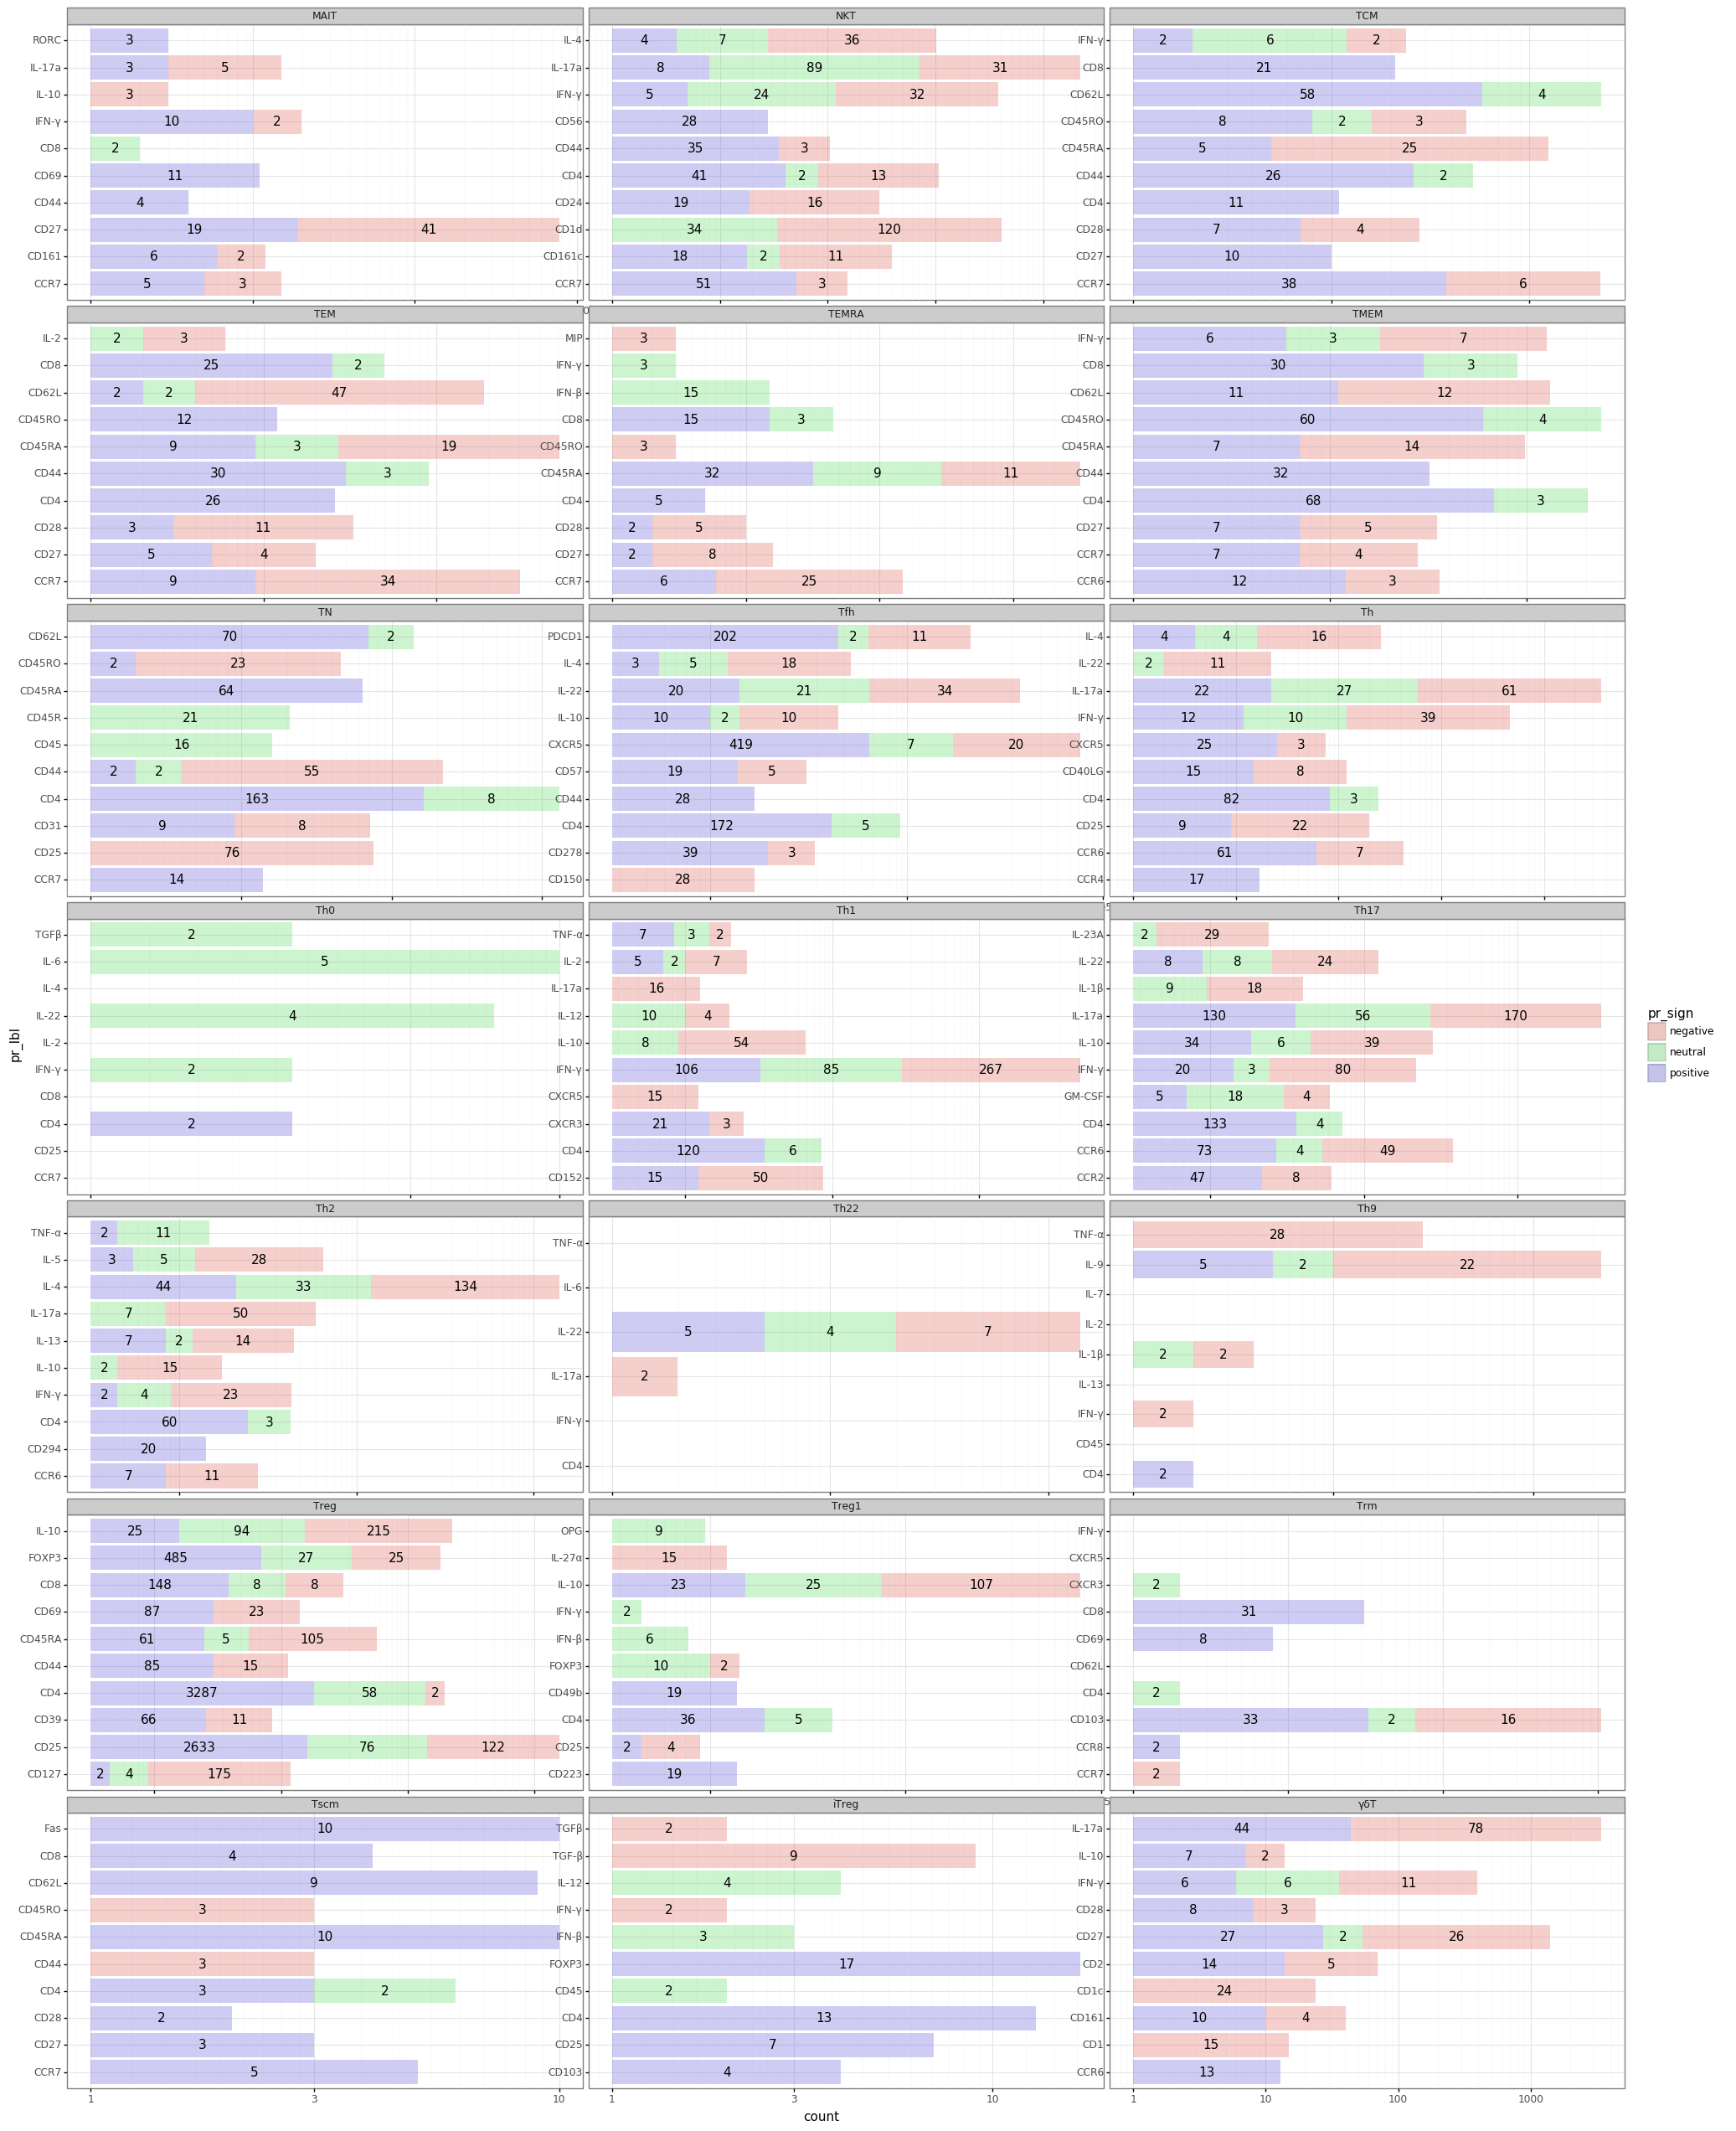

<ggplot: (-9223363243750167222)>

In [69]:
p

#### Visualize phenotype distribution with and without known cell types

In [70]:
assert df_pr_flt['match_ct'].isin([0, 1]).all()

target_cell_types = [
    'Treg', 'Th1', 'Th2', 'TMEM', 'TN', 'Th17', 'TCM',
    'Th', 'NKT', 'γδT', 'TEM', 'Treg1',
    'iTreg', 'TEMRA', 'Tfh', 'Th22',
    'Th0', 'Tscm', 'Th9', 'MAIT', 'Trm'
]

# Restrict stacked protein data frame to only original records where there are 
# at least 2 non-common references (e.g. CD4, CD8)
def accept(r):
    prs = r['prs']
    prs = [p for p in prs if p.token_text not in ['CD4', 'CD8', 'CD8', 'ifi', 'dif']]
    return len(prs) >= 2
df_viz = df_pr_flt[df_pr_flt['row_id'].isin(df_pr_tkn[df_pr_tkn.apply(accept, axis=1)]['row_id'].unique())].copy()

unk_cell_type_max_rows = 10000
common_protein_max = 50

# Sample a set number of rows with no cell type and all rows with a cell type
row_ids = pd.Series(df_viz[df_viz['match_lbl'].isnull()]['row_id'].unique())
row_ids = (
    list(df_viz[df_viz['match_lbl'].notnull()]['row_id'].unique()) + 
    row_ids.sample(min(unk_cell_type_max_rows, len(row_ids)), random_state=1).tolist()
)

def aggfunc(v):
    # Map signs to {+: 2, neutral: 1, -: -1, na: 0}
    if len(v) > 1:
        raise ValueError(str(v))
    return {1: 2, 0: 1, -1: -1}[v.iloc[0]]

def remove_dup_prs(df):
    cts = df.groupby(['row_id', 'pr_lbl']).size().rename('count').reset_index()
    return df[~df['row_id'].isin(cts[cts['count'] >= 2]['row_id'].unique())]

df_embed = (
    df_viz
    .pipe(lambda df: df[df['row_id'].isin(row_ids)])
    # Re-assign label to preferred (shorter) label if possible
    .assign(pr_lbl=lambda df: np.where(df['pr_preflbl'].notnull(), df['pr_preflbl'], df['pr_lbl']))
    # Eliminate rows with multiple references to same protein (e.g. "CD4+ and CD4- cells")
    .pipe(remove_dup_prs)
    # Fill in cell type string with default value (after filtering to target types)
    .pipe(lambda df: df[df['match_lbl'].isin(target_cell_types) | df['match_lbl'].isnull()])
    .assign(match_lbl=lambda df: df['match_lbl'].fillna('NONE'))
    
    # Restrict to n most common proteins
    #.pipe(lambda df: df[df['pr_lbl'].isin(df['pr_lbl'].value_counts().sort_values().tail(common_protein_max).index.values)])
    
    # Pivot to protein indicator matrix for each row
    .assign(ind=1)
    .pivot_table(index=['doc_id', 'row_id', 'match_lbl', 'text'], columns=['pr_lbl'], values='pr_sign', aggfunc=aggfunc)
    .fillna(0)
)
df_embed.head()

pr_lbl                                                             Apo3  BCL6  \
doc_id     row_id match_lbl text                                                
PMC1323501 24     NONE      CD44hi and IFN-γ+ CD8+ T cells          0.0   0.0   
PMC151668  40     NONE      IL-2- or IFNγ-producing T cells         0.0   0.0   
           45     NONE      IL-4- or IFNγ-producing T cells         0.0   0.0   
           47     NONE      IL-4- and IFNγ-producing T cells        0.0   0.0   
PMC1555646 2      NONE      CD4+CD45RO+Foxp3+CD25hi T lymphocytes   0.0   0.0   

pr_lbl                                                             CCL11  \
doc_id     row_id match_lbl text                                           
PMC1323501 24     NONE      CD44hi and IFN-γ+ CD8+ T cells           0.0   
PMC151668  40     NONE      IL-2- or IFNγ-producing T cells          0.0   
           45     NONE      IL-4- or IFNγ-producing T cells          0.0   
           47     NONE      IL-4- and IFNγ-producing T cells         0.0   
PMC1555646 2      NONE      CD4+CD45RO+Foxp3+CD25hi T lymphocytes    0.0   

pr_lbl                                                             CCL16  \
doc_id     row_id match_lbl text                                           
PMC1323501 24     NONE      CD44hi and IFN-γ+ CD8+ T cells           0.0   
PMC151668  40     NONE      IL-2- or IFNγ-producing T cells          0.0   
           45     NONE      IL-4- or IFNγ-producing T cells          0.0   
           47     NONE      IL-4- and IFNγ-producing T cells         0.0   
PMC1555646 2      NONE      CD4+CD45RO+Foxp3+CD25hi T lymphocytes    0.0   

pr_lbl                                                             CCL22  \
doc_id     row_id match_lbl text                                           
PMC1323501 24     NONE      CD44hi and IFN-γ+ CD8+ T cells           0.0   
PMC151668  40     NONE      IL-2- or IFNγ-producing T cells          0.0   
           45     NONE      IL-4- or IFNγ-producing T cells          0.0   
           47     NONE      IL-4- and IFNγ-producing T cells         0.0   
PMC1555646 2      NONE      CD4+CD45RO+Foxp3+CD25hi T lymphocytes    0.0   

pr_lbl                                                             CCL25  \
doc_id     row_id match_lbl text                                           
PMC1323501 24     NONE      CD44hi and IFN-γ+ CD8+ T cells           0.0   
PMC151668  40     NONE      IL-2- or IFNγ-producing T cells          0.0   
           45     NONE      IL-4- or IFNγ-producing T cells          0.0   
           47     NONE      IL-4- and IFNγ-producing T cells         0.0   
PMC1555646 2      NONE      CD4+CD45RO+Foxp3+CD25hi T lymphocytes    0.0   

pr_lbl                                                             CCL6  \
doc_id     row_id match_lbl text                                          
PMC1323501 24     NONE      CD44hi and IFN-γ+ CD8+ T cells          0.0   
PMC151668  40     NONE      IL-2- or IFNγ-producing T cells         0.0   
           45     NONE      IL-4- or IFNγ-producing T cells         0.0   
           47     NONE      IL-4- and IFNγ-producing T cells        0.0   
PMC1555646 2      NONE      CD4+CD45RO+Foxp3+CD25hi T lymphocytes   0.0   

pr_lbl                                                             CCR10  \
doc_id     row_id match_lbl text                                           
PMC1323501 24     NONE      CD44hi and IFN-γ+ CD8+ T cells           0.0   
PMC151668  40     NONE      IL-2- or IFNγ-producing T cells          0.0   
           45     NONE      IL-4- or IFNγ-producing T cells          0.0   
           47     NONE      IL-4- and IFNγ-producing T cells         0.0   
PMC1555646 2      NONE      CD4+CD45RO+Foxp3+CD25hi T lymphocytes    0.0   

pr_lbl                                                             CCR2  CCR4  \
doc_id     row_id match_lbl text                                                
PMC1323501 24     NONE      CD44hi and IFN-γ+ CD8+ T cells          0.0   0.0  

In [71]:
df_embed.shape

(4874, 210)

In [72]:
df_embed.stack().value_counts()

 0.0    1009906
 2.0       8794
-1.0       3440
 1.0       1400
dtype: int64

In [73]:
import umap
from numba import NumbaPerformanceWarning, NumbaWarning

with warnings.catch_warnings():
    warnings.filterwarnings("ignore", category=NumbaPerformanceWarning)
    warnings.filterwarnings("ignore", category=NumbaWarning)
    Y = umap.UMAP(metric='manhattan', min_dist=.5).fit_transform(df_embed.values)
Y.shape

/opt/conda/envs/nlp/lib/python3.6/site-packages/umap/spectral.py:229: UserWarning: Embedding a total of 13 separate connected components using meta-embedding (experimental)
  n_components


(4874, 2)

In [604]:
import plotly
import plotly.plotly as py
from plotly import graph_objs as go
plotly.offline.init_notebook_mode()

In [74]:
df_embed.reset_index()['match_lbl'].unique()

array(['NONE', 'TMEM', 'Treg', 'TN', 'Th', 'Th2', 'iTreg', 'Th1', 'NKT',
       'Th17', 'Tfh', 'TEM', 'γδT', 'TCM', 'Th0', 'Treg1', 'TEMRA',
       'Tscm', 'Th22', 'MAIT', 'Trm', 'Th9'], dtype=object)

In [75]:
df_umap = pd.DataFrame(Y, index=df_embed.index).add_prefix('X')
primary_cell_types = ['Treg', 'Trm', 'Tscm', 'NKT', 'Th1', 'Th2', 'Th17', 'Tfh', 'NONE']

def get_pr_list(r):
    prs = ['{}{}'.format(pr, {-1: '⁻', 1: '', 2: '⁺'}[v]) for pr, v in r[r != 0].to_dict().items()]
    return ' '.join(sorted(prs))
df_umap['pr_list'] = df_embed.apply(get_pr_list, axis=1)
df_umap['pr_len'] = df_embed.apply(lambda r: (r!=0).sum(), axis=1)
df_umap = df_umap.reset_index()
#df_umap['match_lbl'] = df_umap['match_lbl'].apply(lambda v: v if v in primary_cell_types else 'OTHER')
df_umap.head()

doc_id  row_id match_lbl                                   text  \
0  PMC1323501      24      NONE         CD44hi and IFN-γ+ CD8+ T cells   
1   PMC151668      40      NONE        IL-2- or IFNγ-producing T cells   
2   PMC151668      45      NONE        IL-4- or IFNγ-producing T cells   
3   PMC151668      47      NONE       IL-4- and IFNγ-producing T cells   
4  PMC1555646       2      NONE  CD4+CD45RO+Foxp3+CD25hi T lymphocytes   

          X0         X1             pr_list  pr_len  
0 -17.865631  -6.422640   CD44⁺ CD8⁺ IFN-γ⁺       3  
1  -7.438346  -8.744599        IFN-γ⁻ IL-2⁻       2  
2  -8.408806  -8.714507        IFN-γ⁻ IL-4⁻       2  
3  -8.267008  -8.731550        IFN-γ⁻ IL-4⁻       2  
4 -24.298761  22.874651  CD25⁺ CD45RO⁺ CD4⁺       3

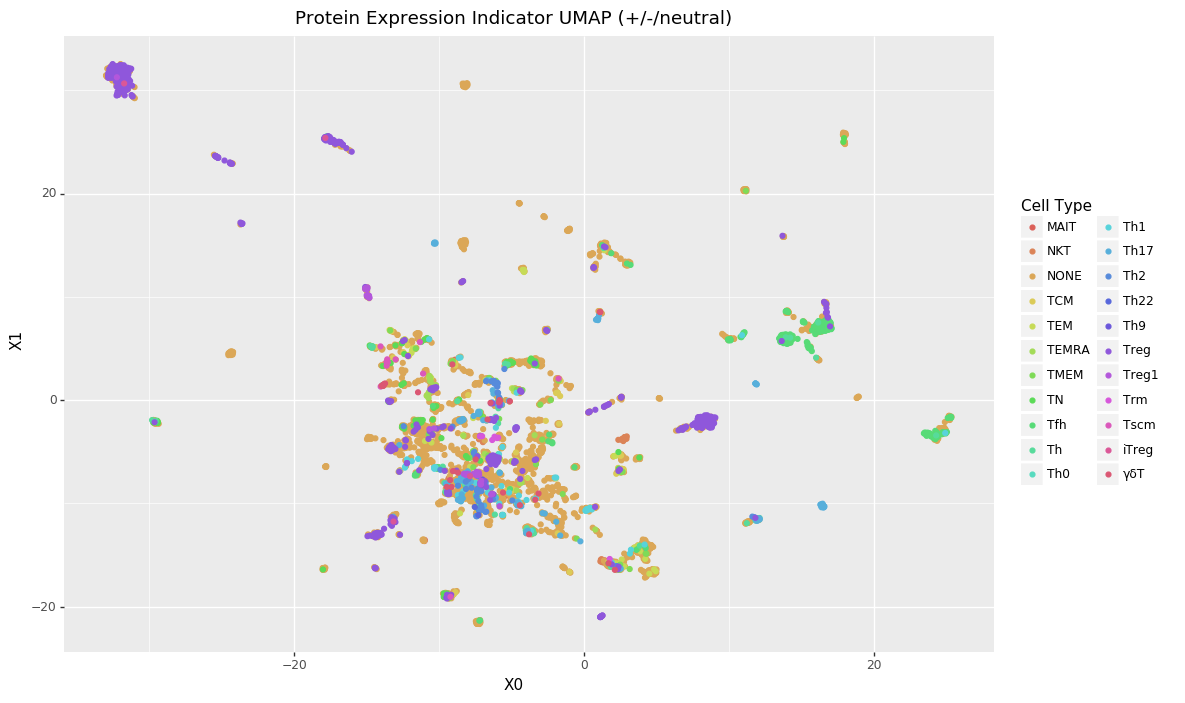

<ggplot: (8793096630536)>

In [76]:
# Static visualization for reference
(
    pn.ggplot(
        df_umap,
        pn.aes(x='X0', y='X1', fill='match_lbl', color='match_lbl')
    ) + 
    pn.geom_point() + 
    pn.labs(title='Protein Expression Indicator UMAP (+/-/neutral)', fill='Cell Type', color='Cell Type') +
    pn.theme(figure_size=(12, 8))
)

In [77]:
def visualize_pair(typ1, typ2):
    return (
        pn.ggplot(
            df_umap.pipe(lambda df: df[df['match_lbl'].isin([typ1, typ2])]),
            pn.aes(x='X0', y='X1', fill='match_lbl', color='match_lbl')
        ) + 
        pn.geom_point(alpha=.3, size=2) + 
        pn.scale_color_brewer(type='qual', palette='Set1') + 
        pn.labs(title=f'Protein Expression Indicator UMAP {typ1}', fill='Cell Type', color='Cell Type') +
        pn.theme_bw() + 
        pn.theme(figure_size=(12, 8))
    )

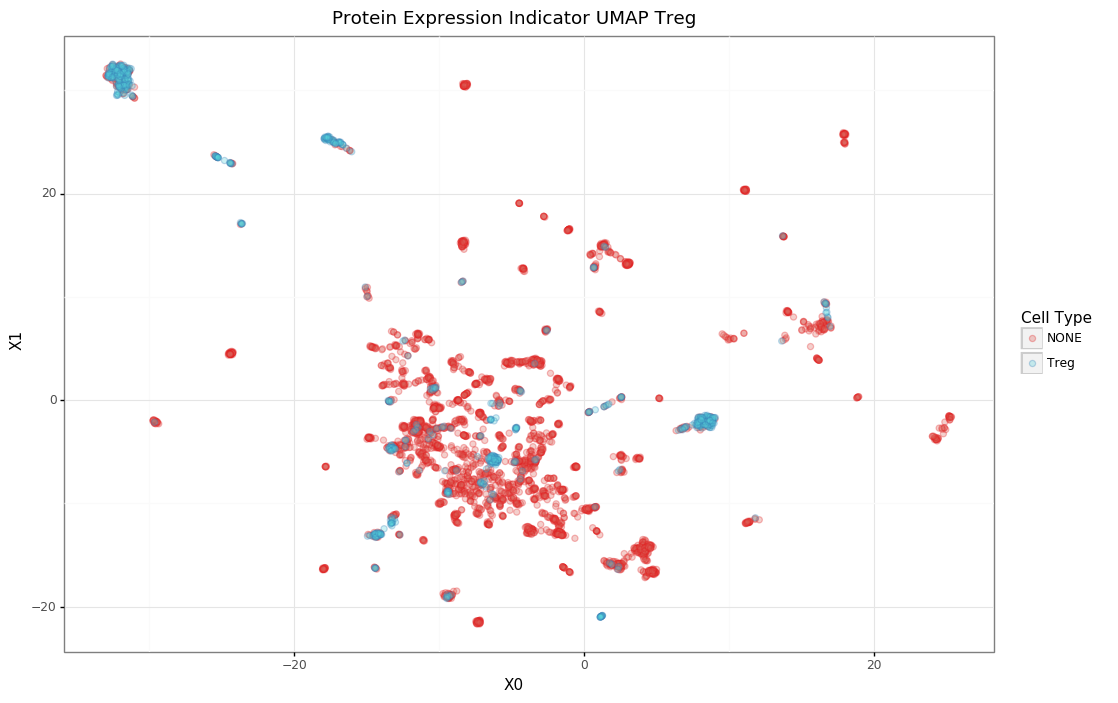

<ggplot: (-9223363243758835957)>

In [78]:
visualize_pair('Treg', 'NONE')

In [707]:
traces = []

for k, g in df_umap.reset_index().groupby('match_lbl'):
    traces.append(go.Scatter(
        x=g['X0'],
        y=g['X1'],
        text=[
            'Cell Type: {}<br>Prs: {}<br>Text: {}<br>RowID: {}<br>DocID: {}'.format(
                g['match_lbl'].iloc[i], g['pr_list'].iloc[i], 
                g['text'].iloc[i], g['row_id'].iloc[i],
                g['doc_id'].iloc[i]
            ) 
            for i in range(len(g))
        ],
        marker=dict(line=dict(width=0)),
        mode='markers',
        name=k
    ))
layout = go.Layout(hovermode='closest')
fig = go.Figure(data=traces, layout=layout)
plotly.offline.iplot(fig) 
# When ready: 
# plotly.tools.set_credentials_file(username='eczech', api_key='#####')
# py.iplot(fig, filename='protein_expression_umap_v1')

Examples within clusters:

- CD4+CD45RO+CXCR5+ **Tfh** cells [[PMC5519210]()]
    - neighbors:
        - CXCR5+ expressing CD4+CD45RO+ T cells [[PMC4504540]()]
        - memory (CD45RO+) CXCR5+CD4+ T cells [[PMC6409398]()]
        - CXCR5hiBTLAhiCD4+ T cells [[PMC4972135]()]
- VP1-specific CD69+/CD103+ tissue-resident memory (**TRM**) cells [[PMC5056763]()]
    - neighbors:
        - human CD69+CD103+ CD8 T cells [[PMC5461007]()]
        - SIINFEKL-specific tetramer-binding resident memory-like CD103+CD69+CXCR3+ CD8 T cells [[PMC5173246]()]
        - intrahepatic CD45RA−CD69+CD103+ CD8 T cells [[PMC5461007]()]
- Tscm CD4+CD45RA+CD45RO−CD62L+CCR7+CD127+CD27+CD28+CD95+CD122+ T (**Tscm**) cell [[PMC4902324]()]
    - neighbors:
        - CD4+CD45RA+CD45RO–CD62L+CCR7+CD127+CD27+CD28+CD95+CD122+T-Cell Subsets [[PMC4902324]()]
        - CD4+CD45RA+CD45RO−CD62L+CCR7+CD127+CD27+CD28+CD95+CD122+ T cells [[PMC4902324]()]
- **Th2** (IL-4+ IFN-γ−) cells [[PMC2212016]()]
    - neighbors:
        - IFN-γ–IL-4+CD4+ T cells [[PMC3767795]()]
        - IL-4+IFN-γ− NKT2 cells [[PMC2193332]()]
        - IL-4/IFN-γ-producing T cells [[PMC4718521]()]

In [493]:
df_viz[df_viz['row_id'] == 17437]

doc_id  end_wrd  match_ct match_lbl               pr_id  \
29041  PMC4515297     4553         0      None  CK216B03A5814616B8   
29042  PMC4515297     4553         0      None           PR:Q12918   
29043  PMC4515297     4553         0      None  CK16DDDB94C109D0EA   

                                                              pr_lbl  \
29041                                                            CD4   
29042  killer cell lectin-like receptor subfamily B member 1 (human)   
29043                                                           CCR6   

                pr_prefid pr_preflbl  pr_sign pr_typ  row_id  start_wrd  \
29041  CK216B03A5814616B8        CD4        1     ck   17437       4549   
29042           PR:Q12918      CD161        1     pr   17437       4549   
29043  CKFD0F253EB33B13FE       CCR6        1     ck   17437       4549   

                           text  
29041  CD4+CD161+CD196+ T cells  
29042  CD4+CD161+CD196+ T cells  
29043  CD4+CD161+CD196+ T cells